In [1]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

from google.cloud import bigquery
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import plotly.express as px
import requests
import seaborn as sns

from scripts.query_incentives import query_airdrops, query_grants, query_airdrop_retention
mpl.rcParams['font.family'] = 'Arial'

In [2]:
with open('data/incentives.json') as f:    
    INCENTIVES = json.load(f)
    

txn_dataframes = []
retention_dataframes = []
for _type, incentives in INCENTIVES.items():
    for i in incentives:
        if _type == 'airdrop':
            dfr = query_airdrop_retention(i)
            dfr['incentive'] = i['name']
            retention_dataframes.append(dfr)
            dft = query_airdrops(i)
        else:
            dft = query_grants(i)
        dft['incentive'] = i['name']
        dft['incentive_type'] = _type
        dft['bucket_week'] = pd.to_datetime(dft['bucket_week']).dt.tz_localize(None)
        incentive_date = pd.to_datetime(i['date'])
        dft['week_count'] = ((dft['bucket_week'] - incentive_date).dt.days // 7)
        txn_dataframes.append(dft)

df_txns = pd.concat(txn_dataframes, axis=0, ignore_index=True)    
df_txns['superchain'] = df_txns.network != 'ARBITRUM_ONE'
df_retention = pd.concat(retention_dataframes, axis=0, ignore_index=True)

Query loaded from local storage.
Query loaded from local storage.
Query loaded from local storage.
Query loaded from local storage.
Query loaded from local storage.
Query loaded from local storage.
Query loaded from local storage.
Query loaded from local storage.
Query loaded from local storage.
Query loaded from local storage.
Query loaded from local storage.
Query loaded from local storage.
Query loaded from local storage.
Query loaded from local storage.


In [3]:
# url = 'https://api.growthepie.xyz/v1/fundamentals_full.json'
# response = requests.get(url)
# df_gtp = pd.DataFrame(response.json())
# df_gtp.to_csv("data/_local/gtp.csv")

df_gtp = pd.read_csv("data/_local/gtp.csv", index_col=0)
df_gtp = df_gtp[df_gtp['metric_key'] == 'txcount']
df_gtp['date'] = pd.to_datetime(df_gtp['date'])
df_gtp.rename(columns={'metric_key': 'Metric'})


BASELINE_CHAINS = ['scroll', 'polygon_zkevm', 'mantle', 'linea', 'blast', 'starknet', 'arbitrum', 'manta']

def get_gtp_baseline(pivot_df, comparison_chains=BASELINE_CHAINS):
    
    df_gtp_baseline = df_gtp[df_gtp.origin_key.isin(comparison_chains)].copy()

    max_date = pivot_df.index.max() + relativedelta(weeks=1)
    min_date = pivot_df.index.min()
    start_weekday = min_date.weekday()
    df_gtp_baseline = df_gtp_baseline[(df_gtp_baseline['date']>=min_date) & (df_gtp_baseline['date']<max_date)]    
    df_gtp_baseline['bucket_week'] = df_gtp_baseline['date'].apply(
        lambda x: x - pd.Timedelta(days=(x.weekday() - start_weekday) % 7) + pd.Timedelta(days=7)
    )
    
    gtp_pivot = df_gtp_baseline.pivot_table(
        index='bucket_week',
        columns='metric_key',
        values='value',
        aggfunc='sum',
        fill_value=0
    ).sort_index()

    return gtp_pivot

In [4]:
df_txns.incentive.unique()

array(['rf_2', 'rf_3', 'rf_4', 'arb_stip_1', 'airdrop_1', 'airdrop_2',
       'airdrop_3', 'airdrop_4', 'arb_airdrop_1'], dtype=object)

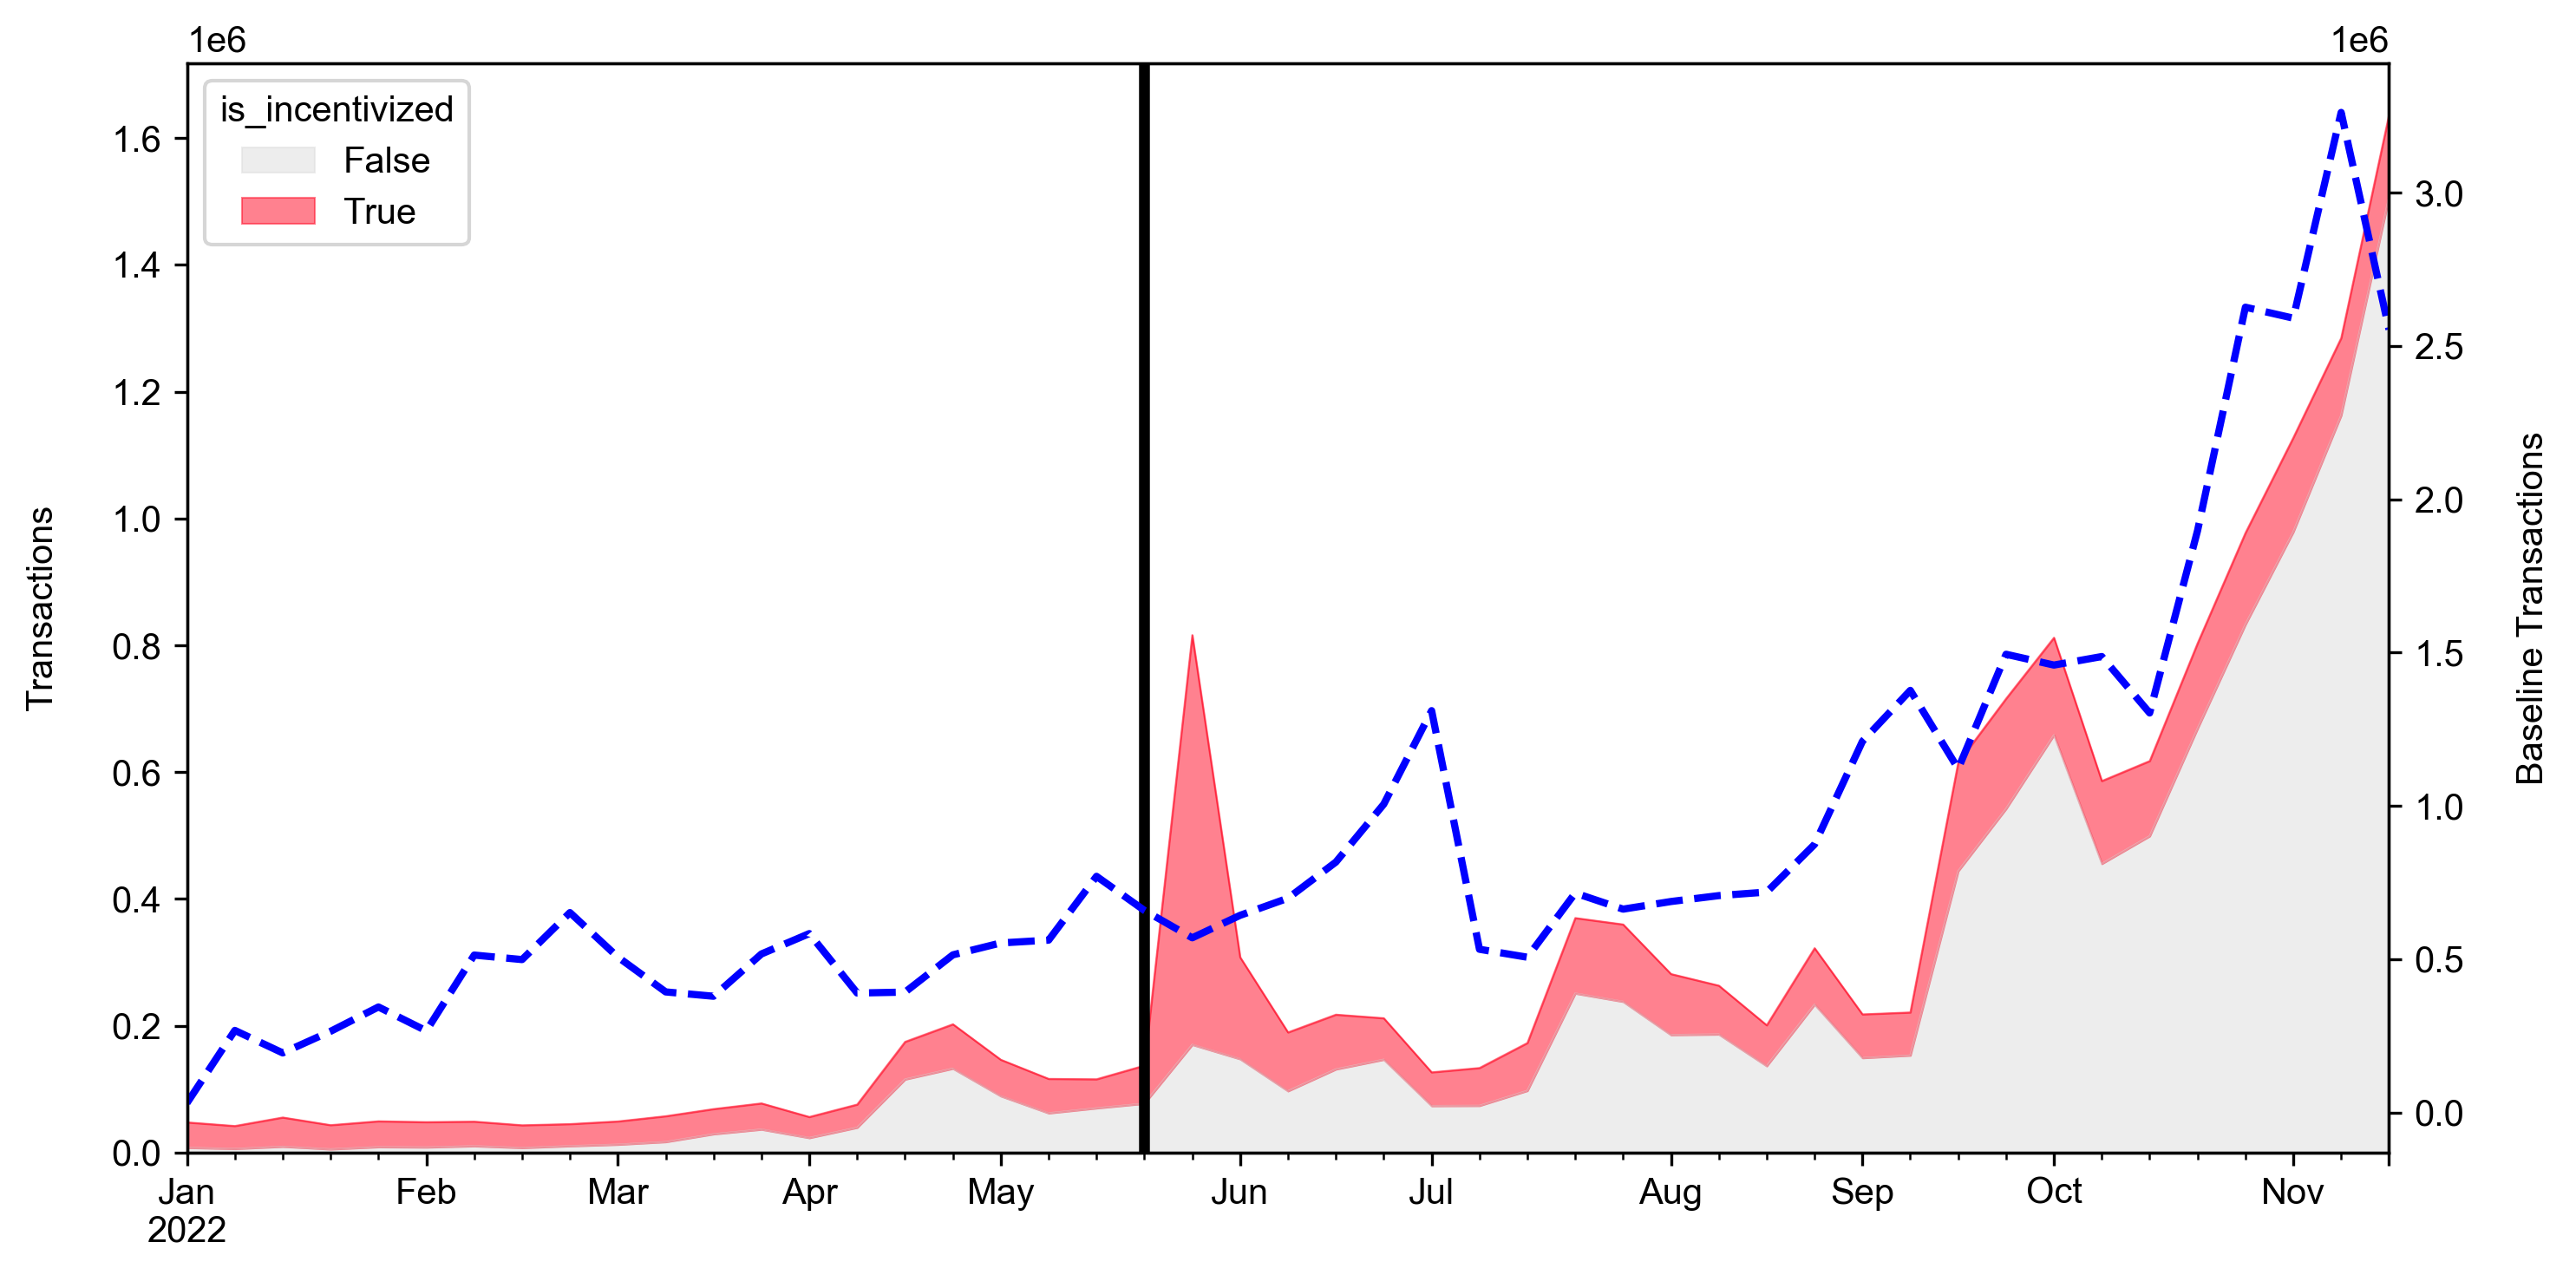

In [5]:
incentive_name = 'airdrop_1'
#chains = ['OPTIMISM', 'MODE', 'ZORA']#, 'MODE', 'ZORA']#, 'BASE', 'MODE', 'ZORA']
chains = ['OPTIMISM']#, 'MODE', 'ZORA']#, 'BASE', 'MODE', 'ZORA']


dff_txns = df_txns[df_txns.network.isin(chains) & (df_txns.incentive == incentive_name)]
incentive_type = list(dff_txns.incentive_type.unique())[0]

for x in INCENTIVES.get(incentive_type):
    if x.get('name') == incentive_name:
        incentive_date = pd.to_datetime(x.get('date'))
        incentive_other_dates = x.get('other_key_dates', [])

df_pivoted_txns = dff_txns.pivot_table(
    index='bucket_week',
    columns='is_incentivized',
    values='count_transactions',
    aggfunc='sum',
    fill_value=0
)
gtp_pivot = get_gtp_baseline(df_pivoted_txns).iloc[:-1]

fig, ax = plt.subplots(figsize=(10,5), dpi=300)

df_pivoted_txns.plot(kind='area', color=['#ddd', '#ff0420'], alpha=.5, lw=.5, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("Transactions\n")

ax.axvline(incentive_date, lw=3, color='black')
# for other_date in incentive_other_dates:
#     ax.axvline(pd.to_datetime(other_date['date']), lw=1, color='black')

ax2 = ax.twinx()
gtp_pivot.plot(color="blue", lw=2, linestyle='--', ax=ax2, legend=False)
xlims = ax.get_xlim()
ax2.set_xlim(xlims)
ax2.set_ylabel("\nBaseline Transactions")

fig.tight_layout()

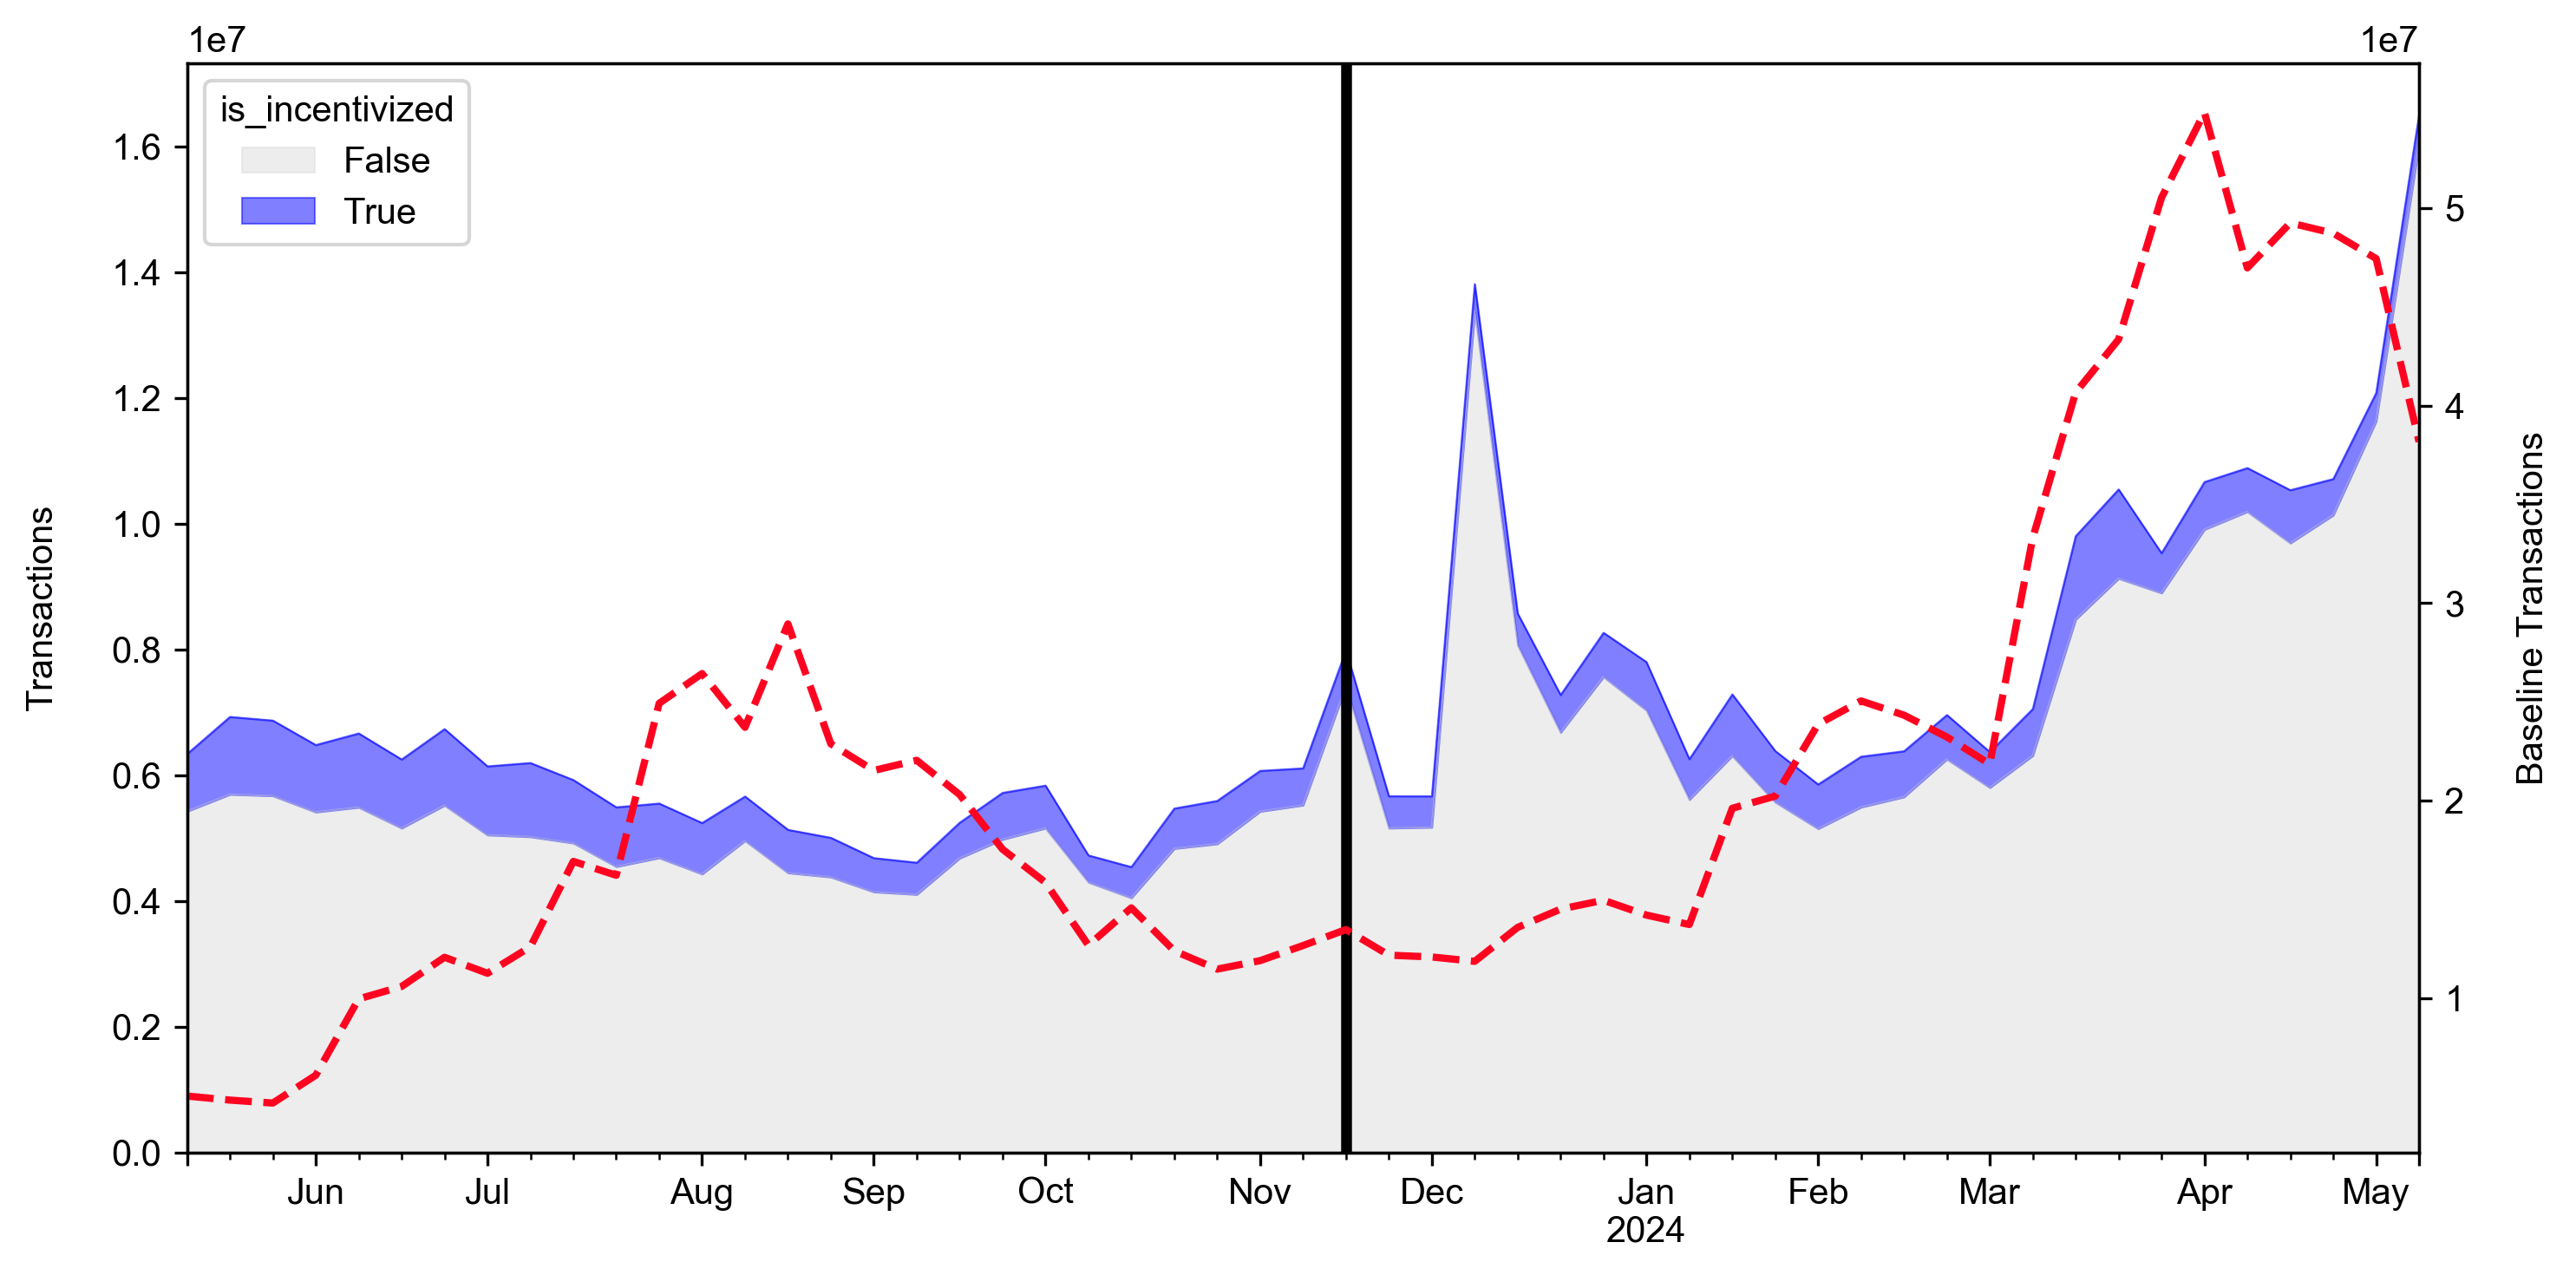

In [6]:
incentive_name = 'arb_stip_1'
chains = ['ARBITRUM_ONE']#, 'MODE', 'ZORA']#, 'BASE', 'MODE', 'ZORA']


dff_txns = df_txns[df_txns.network.isin(chains) & (df_txns.incentive == incentive_name)]
incentive_type = list(dff_txns.incentive_type.unique())[0]

for x in INCENTIVES.get(incentive_type):
    if x.get('name') == incentive_name:
        incentive_date = pd.to_datetime(x.get('date'))
        incentive_other_dates = x.get('other_key_dates', [])

df_pivoted_txns = dff_txns.pivot_table(
    index='bucket_week',
    columns='is_incentivized',
    values='count_transactions',
    aggfunc='sum',
    fill_value=0
)

fig, ax = plt.subplots(figsize=(10,5), dpi=300)

df_pivoted_txns.plot(kind='area', color=['#ddd', 'blue'], alpha=.5, lw=.5, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("Transactions\n")

ax.axvline(incentive_date, lw=3, color='black')
# for other_date in incentive_other_dates:
#     ax.axvline(pd.to_datetime(other_date['date']), lw=1, color='black')

ax2 = ax.twinx()

min_date = df_pivoted_txns.index.min()
max_date = df_pivoted_txns.index.max()

op_pivot = (
    df_txns[df_txns.superchain & df_txns.bucket_week.between(min_date, max_date)]
    .groupby('bucket_week')['count_transactions'].sum()
)
op_pivot.plot(color="#FF0420", lw=2, linestyle='--', ax=ax2, legend=False)
xlims = ax.get_xlim()
ax2.set_xlim(xlims)
ax2.set_ylabel("\nBaseline Transactions")

fig.tight_layout()

In [7]:
df_txns['period'] = df_txns['week_count'].apply(lambda x: 'before-incentive' if x < 0 else 'post_incentive')


(
    df_txns[
        ~df_txns.incentive.isin(['arb_airdrop_1', 'arb_stip_1'])
        & df_txns.network.isin(['OPTIMISM', 'ZORA', 'MODE'])
    ].pivot_table(
        index=['incentive_type', 'incentive'],
        columns=['is_incentivized', 'period'],
        values='count_transactions',
        aggfunc='sum'
    ).applymap(lambda x: round(x/1_000_000,1)))

is_incentivized                     False                           True   \
period                   before-incentive post_incentive before-incentive   
incentive_type incentive                                                    
airdrop        airdrop_1              0.8           10.3              1.1   
               airdrop_2             11.9           26.6             18.9   
               airdrop_3             42.4           55.3              0.8   
               airdrop_4             56.1           70.2              0.3   
retro_grant    rf_2                  28.5           43.4              4.3   
               rf_3                  45.1           63.5              8.8   
               rf_4                  55.8           22.7             16.9   

is_incentivized                          
period                   post_incentive  
incentive_type incentive                 
airdrop        airdrop_1            3.4  
               airdrop_2            6.3  
               airdrop_3            0.6  
               airdrop_4            0.2  
retro_grant    rf_2                 2.1  
               rf_3                 8.8  
               rf_4                 6.9

In [8]:
(
    df_txns[
        df_txns.incentive.isin(['arb_airdrop_1', 'arb_stip_1'])
        & df_txns.network.isin(['ARBITRUM_ONE'])
    ].pivot_table(
        index=['incentive_type', 'incentive'],
        columns=['is_incentivized', 'period'],
        values='count_transactions',
        aggfunc='sum'
    ).applymap(lambda x: round(x/1_000_000,1)))

is_incentivized                         False                           True   \
period                       before-incentive post_incentive before-incentive   
incentive_type incentive                                                        
airdrop        arb_airdrop_1             68.6          141.3             40.3   
retro_grant    arb_stip_1               132.9          206.7             22.3   

is_incentivized                              
period                       post_incentive  
incentive_type incentive                     
airdrop        arb_airdrop_1           28.4  
retro_grant    arb_stip_1              18.4

<Axes: xlabel='weeks_since'>

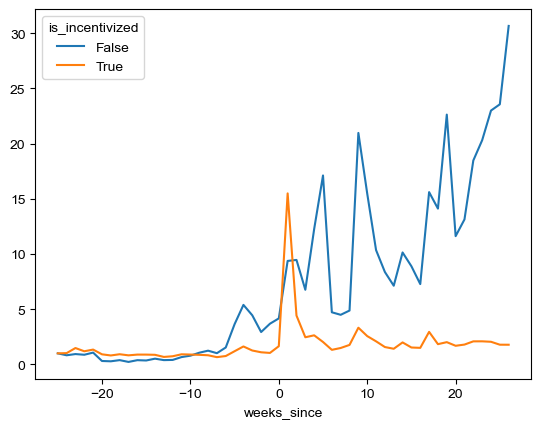

In [9]:
chains = ['OPTIMISM']
incentive = 'airdrop_1'
week_type = 'airdrop'
#incentive = 'arb_airdrop_1'


dff_retention = df_retention[
    (df_retention.week_type==week_type) 
    & (df_retention.network.isin(chains))
    & (df_retention.incentive==incentive)
]

df_cohort = (
    dff_retention.pivot_table(
        index='weeks_since',
        columns='is_incentivized',
        values='count_addresses'
    )
)

(df_cohort / df_cohort.iloc[0]).plot(kind='line')

<Axes: xlabel='weeks_since'>

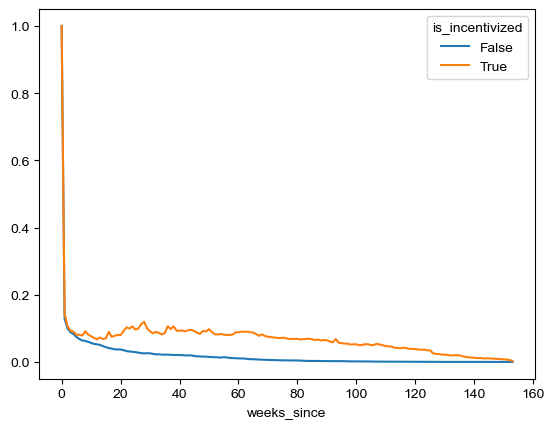

In [10]:
chains = ['OPTIMISM']
incentive = 'airdrop_1'
week_type = 'first_action'
#incentive = 'arb_airdrop_1'


dff_retention = df_retention[
    (df_retention.week_type==week_type) 
    & (df_retention.network.isin(chains))
    & (df_retention.incentive==incentive)
]

df_cohort = (
    dff_retention.pivot_table(
        index='weeks_since',
        columns='is_incentivized',
        values='count_addresses'
    )
)

(df_cohort / df_cohort.iloc[0]).plot(kind='line')

<Axes: xlabel='bucket_week', ylabel='normalized_txns'>

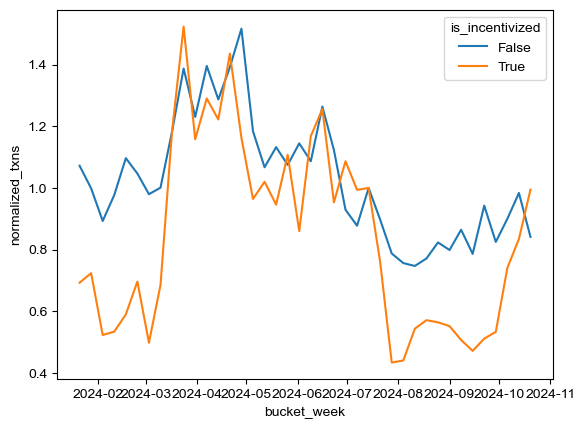

In [11]:
incentive_name = 'rf_4'
chains = ['OPTIMISM']
df_filtered_txns = df_txns[df_txns.network.isin(chains) & (df_txns.incentive == incentive_name)].copy()
    
base_values = (
    df_filtered_txns[df_filtered_txns['week_count'] == -1]
    .set_index('is_incentivized')['count_transactions']
)

df_filtered_txns['normalized_txns'] = df_filtered_txns.apply(
    lambda row: row['count_transactions'] / base_values.get(row['is_incentivized'], None), axis=1)

df_filtered_txns

sns.lineplot(
    data=df_filtered_txns,
    x='bucket_week',
    y='normalized_txns',
    hue='is_incentivized'
)

# Fake plots

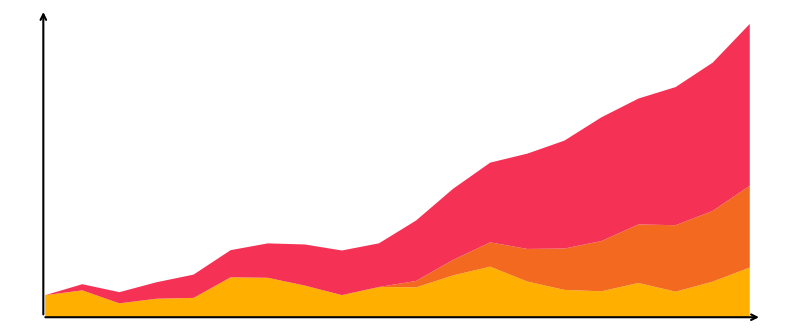

In [12]:
# Create intervals for the new variant with three stacks
intervals = np.arange(0, 20)

stack1_variant = np.array([1.        , 1.21833477, 0.62844748, 0.83805337, 0.8765806 ,
                           1.80965332, 1.7886856 , 1.43505436, 1.00210379, 1.37085228,
                           1.35345295, 1.89776093, 2.2929823 , 1.61945045, 1.23894218,
                           1.17694697, 1.55321544, 1.15813379, 1.61409113, 2.2546871 ])

stack2_variant = np.array([0.        , 0.        , 0.        , 0.        , 0.        ,
                           0.        , 0.        , 0.        , 0.        , 0.        ,
                           0.29164017, 0.70360595, 1.10294327, 1.47741691, 1.87572947,
                           2.27851   , 2.65568508, 3.01509792, 3.20827865, 3.71048579])

stack3_variant = np.array([0.        , 0.27901763, 0.5082139 , 0.74740405, 1.05636946,
                           1.23200382, 1.56060445, 1.86520127, 2.02399155, 1.98121074,
                           2.74069621, 3.22562392, 3.61633702, 4.32291401, 4.89458053,
                           5.61321525, 5.71131946, 6.26569703, 6.72511446, 7.33992757])

data_variant = np.vstack([stack1_variant, stack2_variant, stack3_variant])

fig, ax = plt.subplots(figsize=(10, 4))
ax.stackplot(intervals, data_variant, labels=['Stack 1', 'Stack 2', 'Stack 3'],
             colors=[[1.0, 0.686, 0.0, 1.0], [0.957, 0.412, 0.125, 1.0], [0.961, 0.196, 0.333, 1.0]])

ax.annotate('', xy=(.97, 0), xycoords='axes fraction', xytext=(0.042, 0),
            arrowprops=dict(arrowstyle="->", lw=1.5, color='black'))
ax.annotate('', xy=(0.043, 1), xycoords='axes fraction', xytext=(0.043, 0),
            arrowprops=dict(arrowstyle="->", lw=1.5, color='black'))

sns.despine(ax=ax, left=True, bottom=True)
ax.grid(False)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.set_xlabel('')
ax.set_ylabel('')

plt.show()

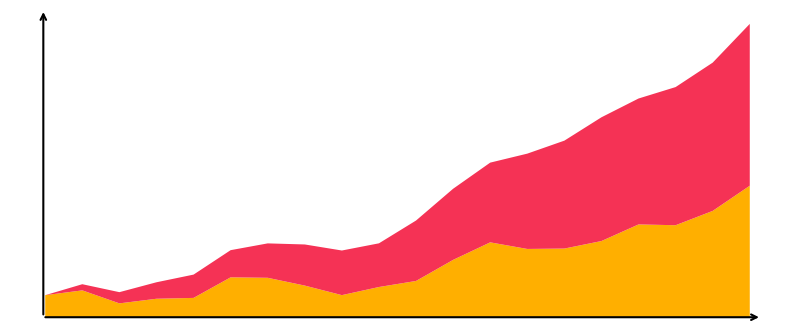

In [13]:
# Create intervals for the new variant with three stacks
intervals = np.arange(0, 20)

stack0_variant = np.zeros(len(intervals))

stack1_variant = np.array([1.        , 1.21833477, 0.62844748, 0.83805337, 0.8765806 ,
                           1.80965332, 1.7886856 , 1.43505436, 1.00210379, 1.37085228,
                           1.35345295, 1.89776093, 2.2929823 , 1.61945045, 1.23894218,
                           1.17694697, 1.55321544, 1.15813379, 1.61409113, 2.2546871 ])

stack2_variant = np.array([0.        , 0.        , 0.        , 0.        , 0.        ,
                           0.        , 0.        , 0.        , 0.        , 0.        ,
                           0.29164017, 0.70360595, 1.10294327, 1.47741691, 1.87572947,
                           2.27851   , 2.65568508, 3.01509792, 3.20827865, 3.71048579])

stack2_variant = stack1_variant + stack2_variant

stack3_variant = np.array([0.        , 0.27901763, 0.5082139 , 0.74740405, 1.05636946,
                           1.23200382, 1.56060445, 1.86520127, 2.02399155, 1.98121074,
                           2.74069621, 3.22562392, 3.61633702, 4.32291401, 4.89458053,
                           5.61321525, 5.71131946, 6.26569703, 6.72511446, 7.33992757])

data_variant = np.vstack([stack2_variant, stack0_variant, stack3_variant])

fig, ax = plt.subplots(figsize=(10, 4))
ax.stackplot(intervals, data_variant, labels=['Stack 1', 'Stack 2', 'Stack 3'],
             colors=[[1.0, 0.686, 0.0, 1.0], [0.957, 0.412, 0.125, 1.0], [0.961, 0.196, 0.333, 1.0]])

ax.annotate('', xy=(.97, 0), xycoords='axes fraction', xytext=(0.042, 0),
            arrowprops=dict(arrowstyle="->", lw=1.5, color='black'))
ax.annotate('', xy=(0.043, 1), xycoords='axes fraction', xytext=(0.043, 0),
            arrowprops=dict(arrowstyle="->", lw=1.5, color='black'))

sns.despine(ax=ax, left=True, bottom=True)
ax.grid(False)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.set_xlabel('')
ax.set_ylabel('')

plt.show()

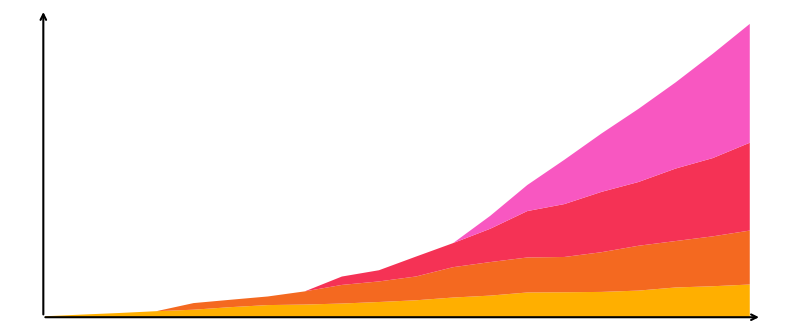

In [14]:
intervals = np.arange(0, 20)

stack1 = np.random.normal(0.1, 0.05, size=len(intervals))
stack1 = np.cumsum(stack1)

stack2 = np.concatenate([np.zeros(4), np.random.normal(0.2, 0.1, size=len(intervals) - 4)])
stack2 = np.cumsum(stack2)

stack3 = np.concatenate([np.zeros(8), np.random.normal(0.4, 0.15, size=len(intervals) - 8)])
stack3 = np.cumsum(stack3)

stack4 = np.concatenate([np.zeros(12), np.random.normal(0.8, 0.2, size=len(intervals) - 12)])
stack4 = np.cumsum(stack4)

data = np.vstack([stack1, stack2, stack3, stack4])

fig, ax = plt.subplots(figsize=(10, 4))
ax.stackplot(intervals, data, labels=['Counterfactual', 'RF7', 'RF8', 'RF9'],
            colors=[[1.0, 0.686, 0.0, 1.0], [0.957, 0.412, 0.125, 1.0],
                     [0.961, 0.196, 0.333, 1.0], [0.973, 0.341, 0.757, 1.0]])

ax.annotate('', xy=(.97, 0), xycoords='axes fraction', xytext=(0.042, 0),
            arrowprops=dict(arrowstyle="->", lw=1.5, color='black'))
ax.annotate('', xy=(0.043, 1), xycoords='axes fraction', xytext=(0.043, 0),
            arrowprops=dict(arrowstyle="->", lw=1.5, color='black'))

sns.despine()
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.grid(False)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.set_xlabel("")
ax.set_ylabel('')

plt.show()